# Testing Different Loss Functions
### Results:
Mean Accuracy of 5 runs: <br>
A: Simple <br>
B: With Pairnorm <br>
C: With Linear <br>
<br>
Accuracy: <br>
&emsp;A: 0.9034 <br>
&emsp;B: 0.907 <br>
&emsp;C: 0.886 <br>
<br>
F1-Score: <br>
&emsp;A: 0.9056 <br>
&emsp;B: 0.9082 <br>
&emsp;C: 0.888 <br>


In [1]:
import os
import torch
from Scripts.Configs.ConfigClass import Config
from lightning.pytorch.callbacks import  ModelCheckpoint
from Scripts.Models.LossFunctions.HeteroLossFunctions import HeteroLoss2
from Scripts.DataManager.GraphConstructor.GraphConstructor import TextGraphType
from Scripts.DataManager.GraphLoader.YelpGraphDataModule import YelpGraphDataModule
from Scripts.Models.LightningModels.LightningModels import HeteroBinaryLightningModel
from Scripts.Models.ModelsManager.ClassifierModelManager import ClassifierModelManager

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\typing.py:90: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
import torch.nn.functional as F
from torch import Tensor
import torch
from torch.nn import Linear
from torch_geometric.nn import BatchNorm, MemPooling, to_hetero, PairNorm
from torch_geometric.data import HeteroData
from Scripts.Models.BaseModels.HeteroGat import HeteroGat
from Scripts.Models.BaseModels.HeteroLinear import HeteroLinear


class HeteroDeepGraphEmbeddingWithLinear(torch.nn.Module):
    
    def __init__(self,
                 input_feature: int, out_features: int,
                 metadata,
                 hidden_feature: int=256,
                 device = 'cpu',
                 dropout=0.1,
                 edge_type_count=9,
                 edge_type_weights=-1,
                 active_keys = ['dep', 'tag', 'word', 'sentence', 'general', 'sentiment'],
                 num_pooling_classes=1
                 ):

        super(HeteroDeepGraphEmbeddingWithLinear, self).__init__()
        self.input_features = input_feature
        self.num_out_features = out_features
        self.hidden_feature: int = hidden_feature
        self.edge_type_count = edge_type_count
        self.edge_type_weights = torch.nn.Parameter(torch.tensor([1]* self.edge_type_count if edge_type_weights==-1 else  edge_type_weights).to(torch.float32), requires_grad=False)

        self.part_weight_norm = torch.nn.LayerNorm((self.edge_type_count,))
        self.norm1 = PairNorm()
        self.norm2 = PairNorm()
        self.drop = torch.nn.Dropout(0.2)
        self.active_keys = active_keys
        
        self.hetero_linear1 = to_hetero(HeteroLinear(self.input_features,self.hidden_feature, use_dropout=False, use_batch_norm=True), metadata)
        
        self.hetero_gat_1 = to_hetero(HeteroGat(self.hidden_feature, self.hidden_feature, dropout, num_heads=2), metadata)
        self.hetero_gat_2 = to_hetero(HeteroGat(self.hidden_feature, self.input_features, dropout, num_heads=2, use_relu=False, use_norm=False, use_dropout=False), metadata)
        
        self.hetero_linear_2 = to_hetero(HeteroLinear(self.hidden_feature, self.hidden_feature, dropout, use_batch_norm=True), metadata)
        
        self.num_pooling_classes = torch.nn.Parameter(torch.tensor(num_pooling_classes).to(torch.int32), requires_grad=False)
        self.mem_pool = MemPooling(self.input_features, self.hidden_feature, 2, self.num_pooling_classes)
        
        self.linear_1 = Linear(self.hidden_feature* self.num_pooling_classes, self.hidden_feature)
        self.linear_2 = Linear(self.hidden_feature, self.hidden_feature)
        self.batch_norm_1 = BatchNorm(self.hidden_feature)
        
        self.output_layer = Linear(self.hidden_feature, self.num_out_features)
        
        self.dep_embedding = torch.nn.Embedding(45, self.input_features)
        self.tag_embedding = torch.nn.Embedding(50, self.input_features)
        self.dep_unembedding = torch.nn.Linear(self.input_features, 45)
        self.tag_unembedding = torch.nn.Linear(self.input_features, 50)
        
        self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
        
        self.x_batches = None
        self.x_batches_cpu = None
        self.x_dict_cpu_1 = None
        self.x_dict_cpu_2 = None
        

    def forward(self, x: HeteroData) -> Tensor:
        self.x_batches = {k:x[k].batch for k in self.active_keys}
        # self.x_batches_cpu = {k:self.x_batches[k].to('cpu') for k in self.active_keys}
        x_dict, edge_attr_dict, edge_index_dict = self.preprocess_data(x)
        edge_attr_dict = self.update_weights(edge_attr_dict, self.pw1)
        x_dict = self.hetero_linear1(x_dict)
        x_dict = self.hetero_gat_1(x_dict, edge_index_dict, edge_attr_dict)
        # self.x_dict_cpu_1 = {k: x_dict[k].to('cpu') for k in x_dict}
        x_dict = self.hetero_linear_2(x_dict)
        # self.normalize(x_dict, self.x_batches, self.norm1)
        x_dict = self.hetero_gat_2(x_dict, edge_index_dict, edge_attr_dict)
        # self.normalize(x_dict, self.x_batches, self.norm2)
        # x_dict_out = self.hetero_linear_2(x_dict)
        # self.x_dict_cpu_2 = {k: x_dict[k].to('cpu') for k in x_dict}
        x_pooled, S = self.mem_pool(x_dict['word'], self.x_batches['word'])
                
        x_pooled = x_pooled.view(x_pooled.shape[0], -1)
        x_pooled = F.relu(self.linear_1(x_pooled))
        x_pooled = F.relu(self.batch_norm_1(self.linear_2(x_pooled)))
        out = self.output_layer(x_pooled)
        
        # x_dict_out = self.hetero_linear_2(x_dict)
        x_dict['dep'] = self.dep_unembedding(x_dict['dep'])
        x_dict['tag'] = self.tag_unembedding(x_dict['tag'])
        
        return out, x_dict

    def preprocess_data(self, x):
        x_dict = {key: x.x_dict[key] for key in x.x_dict}
        if 'dep' in x_dict:
            x_dict['dep'] = self.dep_embedding(x_dict['dep'])
        if 'tag' in x_dict:
            x_dict['tag'] = self.tag_embedding(x_dict['tag'])

        edge_attr_dict = x.edge_attr_dict
        edge_index_dict = x.edge_index_dict

        return x_dict, edge_attr_dict, edge_index_dict

    def normalize(self, x_dict, x_batches, norm_func):
        for k in self.active_keys:
            vecs = x_dict[k]
            if k not in x_batches:
                print('k is not in x_batches')
                continue
            batches = x_batches[k]
            if batches is None:
                print('batches is none')
                continue
            if len(batches) == 0:
                print('batches is empty')
                continue
            
            x_dict[k] = norm_func(vecs, batches)
        return x_dict

    def update_weights(self, edge_attr_dict, part_weights):
        for i, key in enumerate(edge_attr_dict):
            edge_attr = edge_attr_dict[key]
            if edge_attr is None or edge_attr == ('word', 'seq', 'word'):
                continue
            edge_attr_dict[key]= edge_attr * part_weights[i]
        return edge_attr_dict

    def get_scale_same(self, scale:float, attributes: Tensor):
        if attributes is None or len(attributes) == 0:
            return
        attributes = scale * torch.ones_like(attributes)
        return attributes

In [3]:
import torch.nn.functional as F
from torch import Tensor
import torch
from torch.nn import Linear
from torch_geometric.nn import BatchNorm, MemPooling, to_hetero, PairNorm
from torch_geometric.data import HeteroData
from Scripts.Models.BaseModels.HeteroGat import HeteroGat
from Scripts.Models.BaseModels.HeteroLinear import HeteroLinear


class HeteroDeepGraphEmbeddingWithPairNorm(torch.nn.Module):
    
    def __init__(self,
                 input_feature: int, out_features: int,
                 metadata,
                 hidden_feature: int=256,
                 device = 'cpu',
                 dropout=0.1,
                 edge_type_count=9,
                 edge_type_weights=-1,
                 active_keys = ['dep', 'tag', 'word', 'sentence', 'general', 'sentiment'],
                 num_pooling_classes=1
                 ):

        super(HeteroDeepGraphEmbeddingWithPairNorm, self).__init__()
        self.input_features = input_feature
        self.num_out_features = out_features
        self.hidden_feature: int = hidden_feature
        self.edge_type_count = edge_type_count
        self.edge_type_weights = torch.nn.Parameter(torch.tensor([1]* self.edge_type_count if edge_type_weights==-1 else  edge_type_weights).to(torch.float32), requires_grad=False)

        self.part_weight_norm = torch.nn.LayerNorm((self.edge_type_count,))
        self.norm1 = PairNorm()
        self.norm2 = PairNorm()
        self.drop = torch.nn.Dropout(0.2)
        self.active_keys = active_keys
        
        self.hetero_linear1 = to_hetero(HeteroLinear(self.input_features,self.hidden_feature, use_dropout=False, use_batch_norm=True), metadata)
        
        self.hetero_gat_1 = to_hetero(HeteroGat(self.hidden_feature, self.hidden_feature, dropout, num_heads=2), metadata)
        self.hetero_gat_2 = to_hetero(HeteroGat(self.hidden_feature, self.input_features, dropout, num_heads=2, use_relu=False, use_norm=False, use_dropout=False), metadata)
        
        self.hetero_linear_2 = to_hetero(HeteroLinear(self.hidden_feature, self.hidden_feature, dropout, use_batch_norm=True), metadata)
        
        self.num_pooling_classes = torch.nn.Parameter(torch.tensor(num_pooling_classes).to(torch.int32), requires_grad=False)
        self.mem_pool = MemPooling(self.input_features, self.hidden_feature, 2, self.num_pooling_classes)
        
        self.linear_1 = Linear(self.hidden_feature* self.num_pooling_classes, self.hidden_feature)
        self.linear_2 = Linear(self.hidden_feature, self.hidden_feature)
        self.batch_norm_1 = BatchNorm(self.hidden_feature)
        
        self.output_layer = Linear(self.hidden_feature, self.num_out_features)
        
        self.dep_embedding = torch.nn.Embedding(45, self.input_features)
        self.tag_embedding = torch.nn.Embedding(50, self.input_features)
        self.dep_unembedding = torch.nn.Linear(self.input_features, 45)
        self.tag_unembedding = torch.nn.Linear(self.input_features, 50)
        
        self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
        
        self.x_batches = None
        self.x_batches_cpu = None
        self.x_dict_cpu_1 = None
        self.x_dict_cpu_2 = None
        

    def forward(self, x: HeteroData) -> Tensor:
        self.x_batches = {k:x[k].batch for k in self.active_keys}
        # self.x_batches_cpu = {k:self.x_batches[k].to('cpu') for k in self.active_keys}
        x_dict, edge_attr_dict, edge_index_dict = self.preprocess_data(x)
        edge_attr_dict = self.update_weights(edge_attr_dict, self.pw1)
        x_dict = self.hetero_linear1(x_dict)
        x_dict = self.hetero_gat_1(x_dict, edge_index_dict, edge_attr_dict)
        # self.x_dict_cpu_1 = {k: x_dict[k].to('cpu') for k in x_dict}
        # x_dict = self.hetero_linear_2(x_dict)
        self.normalize(x_dict, self.x_batches, self.norm1)
        x_dict = self.hetero_gat_2(x_dict, edge_index_dict, edge_attr_dict)
        # self.normalize(x_dict, self.x_batches, self.norm2)
        # x_dict_out = self.hetero_linear_2(x_dict)
        # self.x_dict_cpu_2 = {k: x_dict[k].to('cpu') for k in x_dict}
        x_pooled, S = self.mem_pool(x_dict['word'], self.x_batches['word'])
                
        x_pooled = x_pooled.view(x_pooled.shape[0], -1)
        x_pooled = F.relu(self.linear_1(x_pooled))
        x_pooled = F.relu(self.batch_norm_1(self.linear_2(x_pooled)))
        out = self.output_layer(x_pooled)
        
        # x_dict_out = self.hetero_linear_2(x_dict)
        x_dict['dep'] = self.dep_unembedding(x_dict['dep'])
        x_dict['tag'] = self.tag_unembedding(x_dict['tag'])
        
        return out, x_dict

    def preprocess_data(self, x):
        x_dict = {key: x.x_dict[key] for key in x.x_dict}
        if 'dep' in x_dict:
            x_dict['dep'] = self.dep_embedding(x_dict['dep'])
        if 'tag' in x_dict:
            x_dict['tag'] = self.tag_embedding(x_dict['tag'])

        edge_attr_dict = x.edge_attr_dict
        edge_index_dict = x.edge_index_dict

        return x_dict, edge_attr_dict, edge_index_dict

    def normalize(self, x_dict, x_batches, norm_func):
        for k in self.active_keys:
            vecs = x_dict[k]
            if k not in x_batches:
                print('k is not in x_batches')
                continue
            batches = x_batches[k]
            if batches is None:
                print('batches is none')
                continue
            if len(batches) == 0:
                print('batches is empty')
                continue
            
            x_dict[k] = norm_func(vecs, batches)
        return x_dict

    def update_weights(self, edge_attr_dict, part_weights):
        for i, key in enumerate(edge_attr_dict):
            edge_attr = edge_attr_dict[key]
            if edge_attr is None or edge_attr == ('word', 'seq', 'word'):
                continue
            edge_attr_dict[key]= edge_attr * part_weights[i]
        return edge_attr_dict

    def get_scale_same(self, scale:float, attributes: Tensor):
        if attributes is None or len(attributes) == 0:
            return
        attributes = scale * torch.ones_like(attributes)
        return attributes

In [4]:
import torch.nn.functional as F
from torch import Tensor
import torch
from torch.nn import Linear
from torch_geometric.nn import BatchNorm, MemPooling, to_hetero, PairNorm
from torch_geometric.data import HeteroData
from Scripts.Models.BaseModels.HeteroGat import HeteroGat
from Scripts.Models.BaseModels.HeteroLinear import HeteroLinear


class HeteroDeepGraphEmbedding(torch.nn.Module):
    
    def __init__(self,
                 input_feature: int, out_features: int,
                 metadata,
                 hidden_feature: int=256,
                 device = 'cpu',
                 dropout=0.1,
                 edge_type_count=9,
                 edge_type_weights=-1,
                 active_keys = ['dep', 'tag', 'word', 'sentence', 'general', 'sentiment'],
                 num_pooling_classes=1
                 ):

        super(HeteroDeepGraphEmbedding, self).__init__()
        self.input_features = input_feature
        self.num_out_features = out_features
        self.hidden_feature: int = hidden_feature
        self.edge_type_count = edge_type_count
        self.edge_type_weights = torch.nn.Parameter(torch.tensor([1]* self.edge_type_count if edge_type_weights==-1 else  edge_type_weights).to(torch.float32), requires_grad=False)

        self.part_weight_norm = torch.nn.LayerNorm((self.edge_type_count,))
        self.norm1 = PairNorm()
        self.norm2 = PairNorm()
        self.drop = torch.nn.Dropout(0.2)
        self.active_keys = active_keys
        
        self.hetero_linear1 = to_hetero(HeteroLinear(self.input_features,self.hidden_feature, use_dropout=False, use_batch_norm=True), metadata)
        
        self.hetero_gat_1 = to_hetero(HeteroGat(self.hidden_feature, self.hidden_feature, dropout, num_heads=2), metadata)
        self.hetero_gat_2 = to_hetero(HeteroGat(self.hidden_feature, self.input_features, dropout, num_heads=2, use_relu=False, use_norm=False, use_dropout=False), metadata)
        
        self.hetero_linear_2 = to_hetero(HeteroLinear(self.hidden_feature, self.hidden_feature, dropout, use_batch_norm=True), metadata)
        
        self.num_pooling_classes = torch.nn.Parameter(torch.tensor(num_pooling_classes).to(torch.int32), requires_grad=False)
        self.mem_pool = MemPooling(self.input_features, self.hidden_feature, 2, self.num_pooling_classes)
        
        self.linear_1 = Linear(self.hidden_feature* self.num_pooling_classes, self.hidden_feature)
        self.linear_2 = Linear(self.hidden_feature, self.hidden_feature)
        self.batch_norm_1 = BatchNorm(self.hidden_feature)
        
        self.output_layer = Linear(self.hidden_feature, self.num_out_features)
        
        self.dep_embedding = torch.nn.Embedding(45, self.input_features)
        self.tag_embedding = torch.nn.Embedding(50, self.input_features)
        self.dep_unembedding = torch.nn.Linear(self.input_features, 45)
        self.tag_unembedding = torch.nn.Linear(self.input_features, 50)
        
        self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
        
        self.x_batches = None
        self.x_batches_cpu = None
        self.x_dict_cpu_1 = None
        self.x_dict_cpu_2 = None
        

    def forward(self, x: HeteroData) -> Tensor:
        self.x_batches = {k:x[k].batch for k in self.active_keys}
        # self.x_batches_cpu = {k:self.x_batches[k].to('cpu') for k in self.active_keys}
        x_dict, edge_attr_dict, edge_index_dict = self.preprocess_data(x)
        edge_attr_dict = self.update_weights(edge_attr_dict, self.pw1)
        x_dict = self.hetero_linear1(x_dict)
        x_dict = self.hetero_gat_1(x_dict, edge_index_dict, edge_attr_dict)
        # self.x_dict_cpu_1 = {k: x_dict[k].to('cpu') for k in x_dict}
        # x_dict = self.hetero_linear_2(x_dict)
        # self.normalize(x_dict, self.x_batches, self.norm1)
        x_dict = self.hetero_gat_2(x_dict, edge_index_dict, edge_attr_dict)
        # self.normalize(x_dict, self.x_batches, self.norm2)
        # x_dict_out = self.hetero_linear_2(x_dict)
        # self.x_dict_cpu_2 = {k: x_dict[k].to('cpu') for k in x_dict}
        x_pooled, S = self.mem_pool(x_dict['word'], self.x_batches['word'])
                
        x_pooled = x_pooled.view(x_pooled.shape[0], -1)
        x_pooled = F.relu(self.linear_1(x_pooled))
        x_pooled = F.relu(self.batch_norm_1(self.linear_2(x_pooled)))
        out = self.output_layer(x_pooled)
        
        # x_dict_out = self.hetero_linear_2(x_dict)
        x_dict['dep'] = self.dep_unembedding(x_dict['dep'])
        x_dict['tag'] = self.tag_unembedding(x_dict['tag'])
        
        return out, x_dict

    def preprocess_data(self, x):
        x_dict = {key: x.x_dict[key] for key in x.x_dict}
        if 'dep' in x_dict:
            x_dict['dep'] = self.dep_embedding(x_dict['dep'])
        if 'tag' in x_dict:
            x_dict['tag'] = self.tag_embedding(x_dict['tag'])

        edge_attr_dict = x.edge_attr_dict
        edge_index_dict = x.edge_index_dict

        return x_dict, edge_attr_dict, edge_index_dict

    def normalize(self, x_dict, x_batches, norm_func):
        for k in self.active_keys:
            vecs = x_dict[k]
            if k not in x_batches:
                print('k is not in x_batches')
                continue
            batches = x_batches[k]
            if batches is None:
                print('batches is none')
                continue
            if len(batches) == 0:
                print('batches is empty')
                continue
            
            x_dict[k] = norm_func(vecs, batches)
        return x_dict

    def update_weights(self, edge_attr_dict, part_weights):
        for i, key in enumerate(edge_attr_dict):
            edge_attr = edge_attr_dict[key]
            if edge_attr is None or edge_attr == ('word', 'seq', 'word'):
                continue
            edge_attr_dict[key]= edge_attr * part_weights[i]
        return edge_attr_dict

    def get_scale_same(self, scale:float, attributes: Tensor):
        if attributes is None or len(attributes) == 0:
            return
        attributes = scale * torch.ones_like(attributes)
        return attributes

In [5]:
config = Config(r'C:\Users\fardin\Projects\ColorIntelligence')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256
edge_type_weights = [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.]

graph_type = TextGraphType.SENTIMENT

metadata = (['dep', 'tag', 'word', 'sentence', 'general', 'sentiment'],
 [('dep', 'dep_word', 'word'),
  ('word', 'word_dep', 'dep'),
  ('tag', 'tag_word', 'word'),
  ('word', 'word_tag', 'tag'),
  ('word', 'seq', 'word'),
  ('general', 'general_sentence', 'sentence'),
  ('sentence', 'sentence_general', 'general'),
  ('word', 'word_sentence', 'sentence'),
  ('sentence', 'sentence_word', 'word'),
  ('word', 'word_sentiment', 'sentiment'),
  ('sentiment', 'sentiment_word', 'word')])

In [6]:
from torch import nn
from typing import List
from Scripts.Models.LossFunctions.HeteroLossArgs import HeteroLossArgs

class HeteroLoss(torch.nn.Module):
    def __init__(self, exception_keys: List[str], enc_factor=0.0, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.bce_loss=  nn.BCEWithLogitsLoss()
        self.mse_loss = nn.MSELoss()
        self.exception_keys = exception_keys
        self.enc_factor = enc_factor
    
    def forward(self, out_pred: HeteroLossArgs, out_main: HeteroLossArgs):
        loss = 0 
        y_main = nn.functional.one_hot(out_main.y.to(torch.long)).to(torch.float32)
        for i in range(y_main.shape[1]):
            i_indices = torch.argwhere(y_main[:,i])[:,0]
            loss += self.bce_loss(out_pred.y[i_indices], out_main.y[i_indices])
            
        x_dict_keys = [k for k in out_pred.x_dict.keys() if k not in self.exception_keys]
        for key in x_dict_keys:
            tensor1 = out_pred.x_dict[key]
            tensor2 = out_main.x_dict[key]
            if tensor2.ndim == 1 and tensor2.dtype is torch.long:
                tensor2 = torch.nn.functional.one_hot(input=tensor2.to(torch.long), num_classes=tensor1.shape[1]).to(torch.float32)
            loss += self.enc_factor * (self.mse_loss(tensor1, tensor2)) # !?
        return loss

In [7]:
data_manager =  YelpGraphDataModule(config, True, True, test_size=0.05, val_size=0.05, shuffle=False, start_data_load=0 , end_data_load = 10000, device='cpu', batch_size=batch_size, graph_type=graph_type, load_preprocessed_data = True)
data_manager.load_labels()
data_manager.load_graphs()

filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 10/10 [02:38<00:00, 15.87s/it]

self.shuffle: False


In [8]:
# t_dataloader = data_manager.test_dataloader()
# Xa,Ya = next(iter(t_dataloader))

In [9]:
# graph_embedding = HeteroDeepGraphEmbedding(300, 1, metadata, 32, dropout=0.2, edge_type_count=11, edge_type_weights=edge_type_weights)
# graph_embedding_with_linear = HeteroDeepGraphEmbeddingWithLinear(300, 1, metadata, 32, dropout=0.2, edge_type_count=11, edge_type_weights=edge_type_weights)
# graph_embedding_with_pair_norm = HeteroDeepGraphEmbeddingWithPairNorm(300, 1, metadata, 32, dropout=0.2, edge_type_count=11, edge_type_weights=edge_type_weights)

In [10]:
# graph_embedding.to(device)
# graph_embedding(Xa.to(device))
# graph_embedding_with_linear.to(device)
# graph_embedding_with_linear(Xa.to(device))
# graph_embedding_with_pair_norm.to(device)
# graph_embedding_with_pair_norm(Xa.to(device))

In [11]:
enc_factors = [0.001]

In [12]:
edge_type_weights

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0]

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
C:\Users\fardin\AppData\Local\Temp\ipykernel_18952\2620029369.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

Adjusting learning rate of group 0 to 4.5000e-03.


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


bbbb


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                     | Params
-------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding | 387 K 
1 | loss_func | HeteroLoss               | 0     
2 | train_acc | BinaryAccuracy           | 0     
3 | val_acc   | BinaryAccuracy           | 0     
4 | test_acc  | BinaryAccuracy           | 0     
-------------------------------------------------------
387 K     Trainable params
23        Non-trainable params
387 K     Total params
1.550     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightn

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


C:\Users\fardin\AppData\Local\Temp\ipykernel_18952\2620029369.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                     | Params
-------------------------------------------------------
0 | model     | HeteroDeepG

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


C:\Users\fardin\AppData\Local\Temp\ipykernel_18952\2620029369.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                     | Params
-------------------------------------------------------
0 | model     | HeteroDeepG

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


C:\Users\fardin\AppData\Local\Temp\ipykernel_18952\2620029369.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                     | Params
-------------------------------------------------------
0 | model     | HeteroDeepG

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


C:\Users\fardin\AppData\Local\Temp\ipykernel_18952\2896951555.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                               | Params
-----------------------------------------------------------------
0 | mod

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


C:\Users\fardin\AppData\Local\Temp\ipykernel_18952\2896951555.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                               | Params
-----------------------------------------------------------------
0 | mod

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])


C:\Users\fardin\AppData\Local\Temp\ipykernel_18952\2896951555.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Adjusting learning rate of group 0 to 4.5000e-03.
bbbb


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                               | Params
-----------------------------------------------------------------
0 | model     | HeteroDeepGraphEmbeddingWithLinear | 387 K 
1 | loss_func | HeteroLoss                         | 0     
2 | train_acc | BinaryAccuracy                     | 0     
3 | val_acc   | BinaryAccuracy                     | 0     
4 | test_acc  | BinaryAccuracy                     | 0     
-----------------------------------------------------------------
387 K     Trainable params
23        Non-trainable params
387 K     Total params
1.550     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


C:\Users\fardin\AppData\Local\Temp\ipykernel_18952\2896951555.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                               | Params
-----------------------------------------------------------------
0 | mod

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


C:\Users\fardin\AppData\Local\Temp\ipykernel_18952\3612598303.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                 | Params
-------------------------------------------------------------------
0 |

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


C:\Users\fardin\AppData\Local\Temp\ipykernel_18952\3612598303.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                 | Params
-------------------------------------------------------------------
0 |

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])


C:\Users\fardin\AppData\Local\Temp\ipykernel_18952\3612598303.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


Adjusting learning rate of group 0 to 4.5000e-03.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                 | Params
-------------------------------------------------------------------
0 | model     | HeteroDeepGraphEmbeddingWithPairNorm | 387 K 
1 | loss_func | HeteroLoss                           | 0     
2 | train_acc | BinaryAccuracy                       | 0     
3 | val_acc   | BinaryAccuracy                       | 0     
4 | test_acc  | BinaryAccuracy                       | 0     
-------------------------------------------------------------------
387 K     Trainable params
23        Non-trainable params
387 K     Total params
1.550     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not h

bbbb


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


C:\Users\fardin\AppData\Local\Temp\ipykernel_18952\3612598303.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                 | Params
-------------------------------------------------------------------
0 |

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])
torch.Size([500, 1])


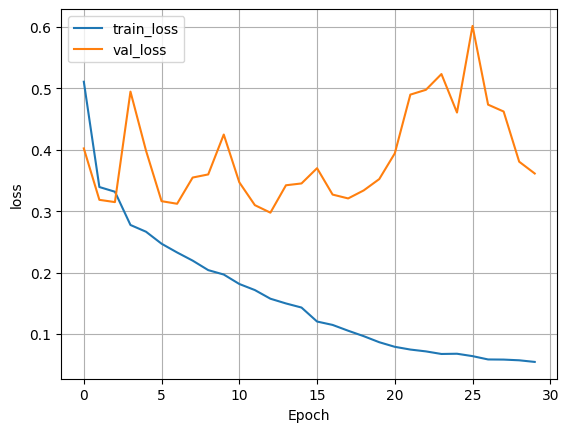

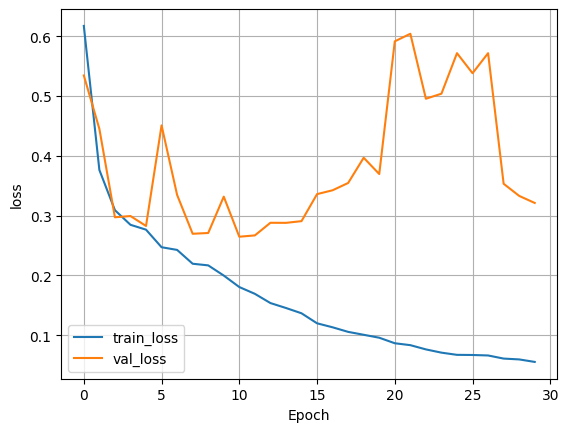

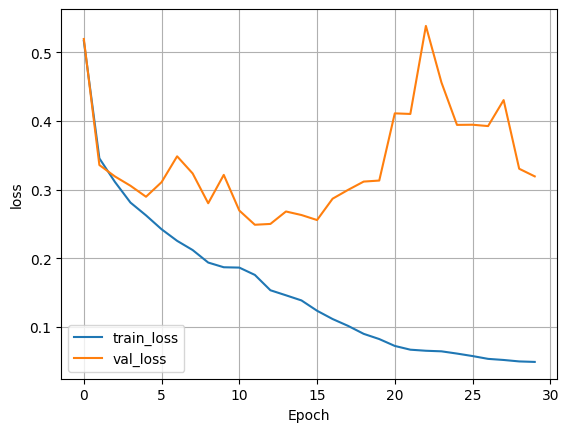

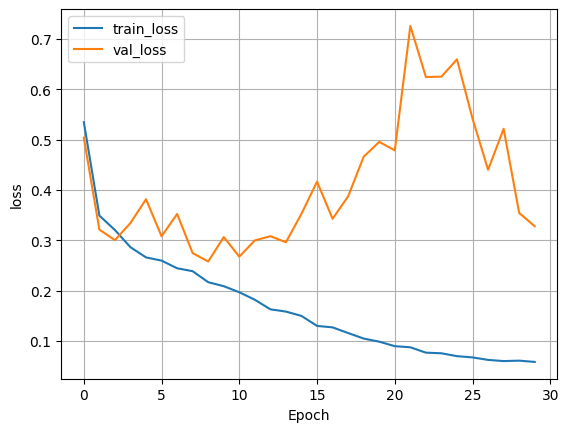

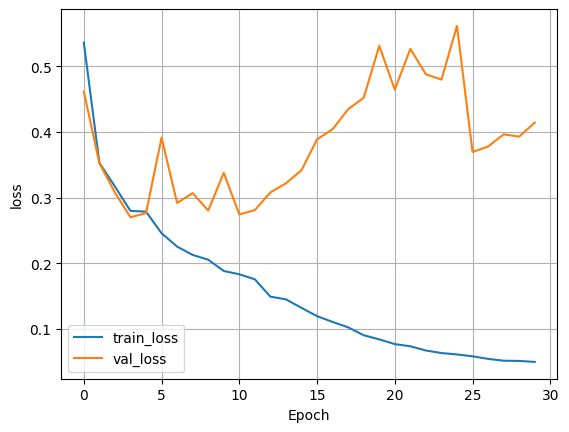

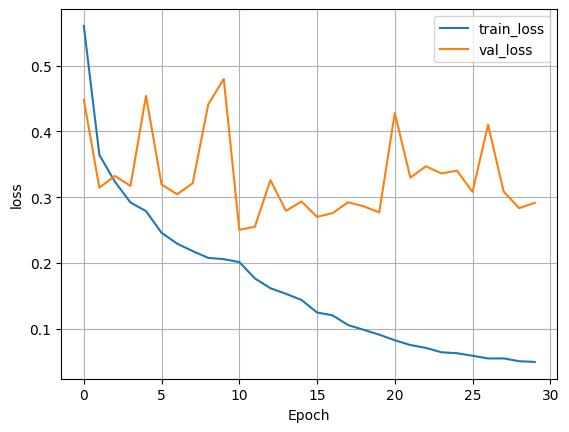

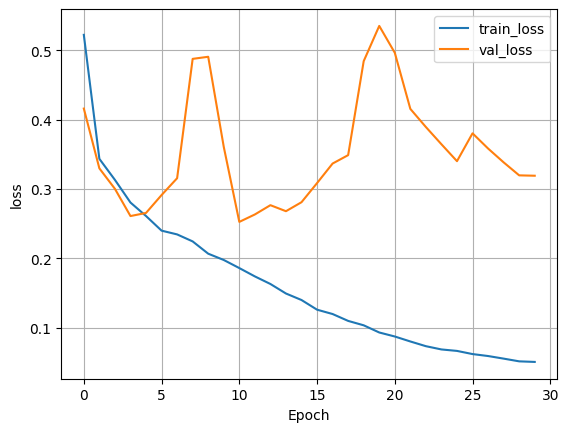

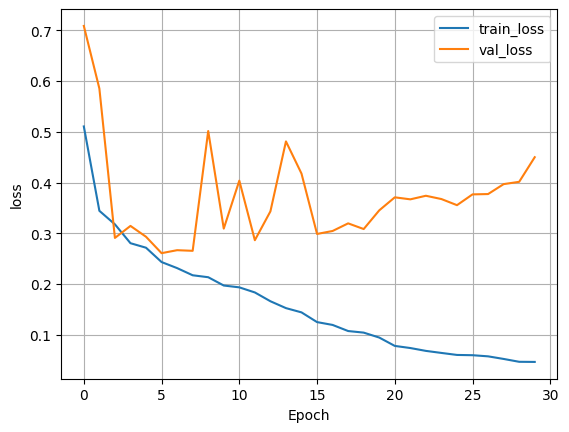

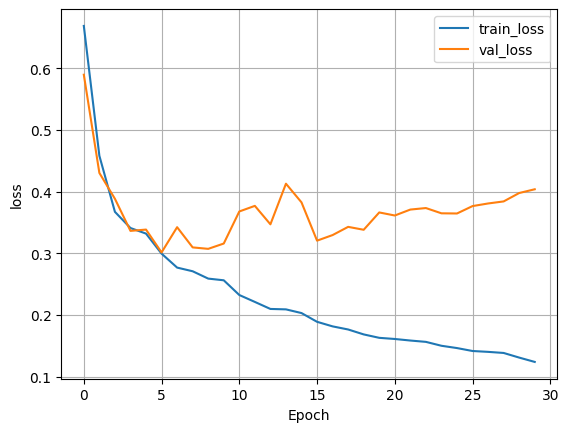

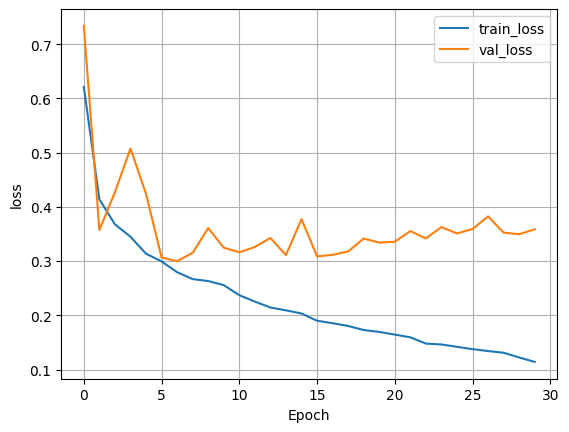

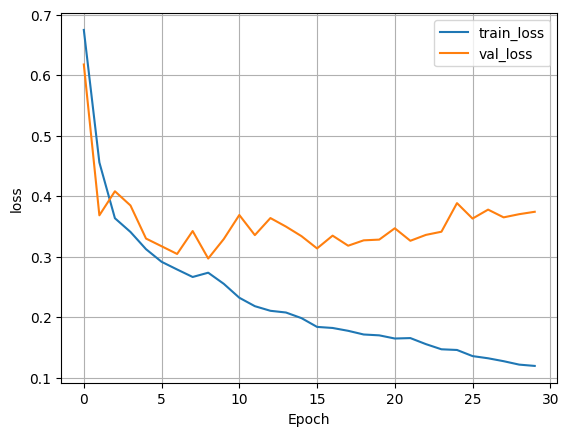

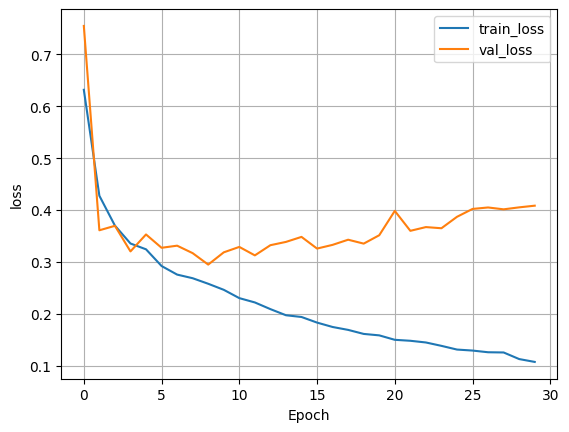

In [13]:
loss_functions = { 'HeteroLoss': HeteroLoss}
model_types = {'Simple': HeteroDeepGraphEmbedding, 'WithLinear': HeteroDeepGraphEmbeddingWithLinear, 'WithPairNorm': HeteroDeepGraphEmbeddingWithPairNorm}
max_epochs = 30
callbacks = [
ModelCheckpoint(save_top_k=5, mode='max', monitor='val_acc', save_last=True)
]
for model_type in model_types:
    for loss_f in loss_functions:
        for i in range(5):
            graph_embedding = model_types[model_type](300, 1, metadata, 32, dropout=0.2, edge_type_count=11, edge_type_weights=edge_type_weights)
            graph_embedding.to(device)
            loss_func = HeteroLoss(exception_keys=['word'], enc_factor=0.001)
            optimizer = torch.optim.Adam(graph_embedding.parameters(), lr=0.0045, weight_decay=0.0015)
            lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 20, 28, 35], gamma=0.5, verbose=True)
            lightning_model = HeteroBinaryLightningModel(graph_embedding,
                                                optimizer=optimizer,
                                                loss_func=loss_func,
                                                learning_rate=0.045,
                                                batch_size=batch_size,
                                                user_lr_scheduler=True,
                                                lr_scheduler=lr_scheduler,
                                                min_lr=0.0005
                                                ).to(device)
            model_manager = ClassifierModelManager(graph_embedding, lightning_model, log_name='Hetero-Loss-Tests-6-new-models',device=device, num_train_epoch=max_epochs)

            model_manager.fit(datamodule=data_manager, max_epochs=max_epochs)
            model_manager.save_plot_csv_logger(loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'], name_prepend=f'test_{model_type}_{loss_f}_{i}')
            model_manager.torch_model.to(device)
            model_manager.lightning_module = HeteroBinaryLightningModel.load_from_checkpoint(model_manager.trainer.checkpoint_callback.best_model_path, model=model_manager.torch_model)
            model_manager.save_evaluation(data_manager.val_dataloader(), f'test_{model_type}_{loss_f}_{i})',True, True, True, True, True, True, True, multi_class=False)